In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving faces.zip to faces.zip
User uploaded file "faces.zip" with length 2192568 bytes


In [2]:
!unzip "faces.zip"

Archive:  faces.zip
  inflating: faces/src.txt           
   creating: faces/Testing/
  inflating: faces/Testing/10-188C551C-39E7-4A43-9163-D8054DFBEA64.webp  
  inflating: faces/Testing/fbe2a2e84692458b1a5fd1c33ef37243.jpg  
   creating: faces/Training/
  inflating: faces/Training/16.jpg   
  inflating: faces/Training/17.jpg   
  inflating: faces/Training/18.jpg   
  inflating: faces/Training/19.jpg   
  inflating: faces/Training/20.jpg   
  inflating: faces/Training/21.jpg   
  inflating: faces/Training/22.jpg   
  inflating: faces/Training/23.jpg   
  inflating: faces/Training/24.jpg   
  inflating: faces/Training/25.jpg   
  inflating: faces/Training/26.jpg   
  inflating: faces/Training/27.jpg   
  inflating: faces/Training/28.jpg   
  inflating: faces/Training/29.jpg   
  inflating: faces/Training/30.jpg   
  inflating: faces/Training/31.jpg   
  inflating: faces/Training/32.jpg   
  inflating: faces/Training/33.jpg   
  inflating: faces/Training/34.jpg   
  inflating: faces/Trai

In [3]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Image Process for reading all the image and creating a label (0 for no face and 1 for face)

In [4]:
def image_process(src,path):
  images=[]
  label=[]
  features= np.array([])
  for i in src:
    img = cv2.imread(os.path.join(path,i),0)
    img = cv2.resize(img, (200, 300))  
    images.append(img)
    if("png" in i):
      label.append(1)
    else:
      label.append(0)
  return images,label

Reading image

In [5]:
features= np.array([])


train_path = "/content/faces/Training"
training_names = os.listdir(train_path)

images,labels = image_process(training_names,train_path)


In [6]:
from google.colab.patches import cv2_imshow

In [7]:
labels

[0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0]

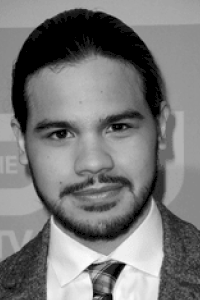

In [8]:
cv2_imshow(images[3])

In [9]:
from skimage.feature import hog

Hog Processing

In [10]:
hog_images = []
hog_features = []
for image in images:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(1, 1), visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

Hog Result

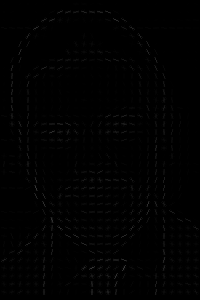

In [11]:
cv2_imshow(hog_images[3])

In [12]:
from sklearn import svm

In [13]:
labels=np.array(labels)

In [14]:
labels.shape

(40,)

Model using SVC

In [15]:
clf = svm.SVC(probability=True)
hog_features = np.array(hog_features)

Model Training

In [16]:
clf.fit(hog_features,labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Testing for image with face

In [17]:
pred = cv2.imread("/content/faces/Testing/10-188C551C-39E7-4A43-9163-D8054DFBEA64.webp",0)
pred = cv2.resize(pred, (200, 300)) 
y_ft,y_pred=hog(pred, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(1, 1), visualize=True)

In [18]:
y_ft = y_ft.reshape(1,-1)

In [19]:
result = clf.predict(y_ft)

In [20]:
result

array([1])

Testing for image with no face

In [21]:

pred = cv2.imread("/content/faces/Testing/fbe2a2e84692458b1a5fd1c33ef37243.jpg",0)
pred = cv2.resize(pred, (200, 300)) 
y_ft,y_pred=hog(pred, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(1, 1), visualize=True)

In [22]:
y_ft = y_ft.reshape(1,-1)

In [23]:
result = clf.predict(y_ft)

In [24]:
result

array([0])

Sliding Window

In [25]:
# import the necessary packages
import imutils
def yieldimg(image):
	# yield the original image
	yield image

def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

[[0.0947214 0.9052786]]
[[0.08904809 0.91095191]]
[[0.19536521 0.80463479]]


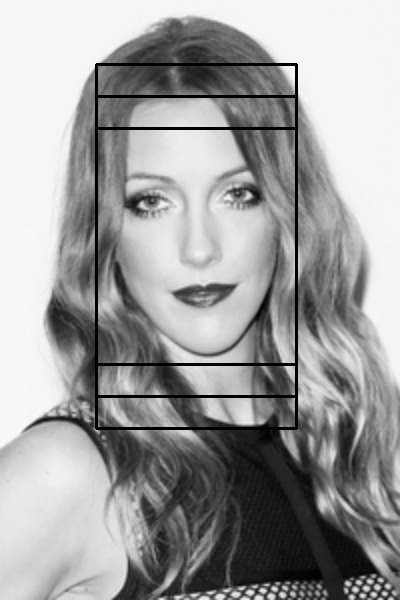

In [26]:
image_test = cv2.imread("/content/faces/Testing/10-188C551C-39E7-4A43-9163-D8054DFBEA64.webp",0)
image_test = cv2.resize(image_test, (400, 600)) 
(winW, winH) = (200, 300)



bounding_boxes=[]
confidence_scores=[]
  
for resized in yieldimg(image_test): 
  clone = image_test.copy()
  for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
  # if the window does not meet our desired window size, ignore it
    if (window.shape[0] != winH or window.shape[1] != winW):
      continue
    # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
    # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
    # WINDOW
    test_ft,test_pred=hog(window, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(1, 1), visualize=True)
    test_ft = test_ft.reshape(1,-1)
    if (clf.predict(test_ft)==1 and clf.predict_proba(test_ft)[:,1]>0.8):
      print(clf.predict_proba(test_ft))
      cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
      bounding_boxes.append((x,y,x+winW,y+winH))
      confidence_scores.append(clf.predict_proba(test_ft)[:,1])
  cv2_imshow(clone)

		



In [27]:
bounding_boxes

[(96, 64, 296, 364), (96, 96, 296, 396), (96, 128, 296, 428)]

In [28]:
confidence_scores

[array([0.9052786]), array([0.91095191]), array([0.80463479])]

Change Bounding Box and Confidence score into Numpy array

In [29]:
threshold = 0.4

In [30]:
bounding_boxes = np.array(bounding_boxes)
confidence_scores = np.array(confidence_scores)

Using non-max suppression algorithm to remove the overlapping box

In [31]:
def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score



Using the NMS

In [32]:
picked_boxes, picked_score=nms(bounding_boxes, confidence_scores, threshold)

In [33]:
picked_boxes

[array([[ 96,  64, 296, 364]])]

In [34]:
picked_score

[array([[0.9052786]])]

Extract where the box will start and end

In [35]:
start_x=picked_boxes[0][0][0]
start_y=picked_boxes[0][0][1]
end_x=picked_boxes[0][0][2]
end_y=picked_boxes[0][0][3]
confidence = confidence_scores[0]

Show the result

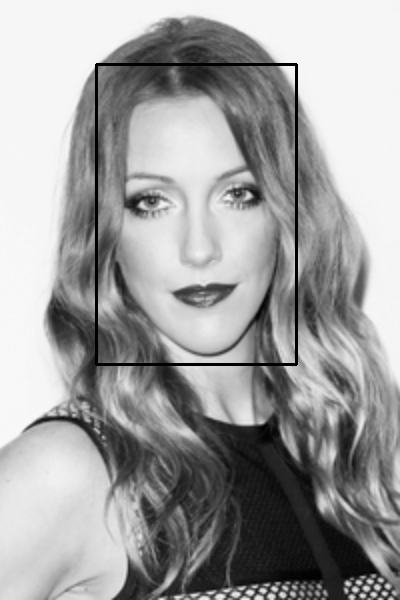

In [36]:
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
thickness = 2
fin_img = image_test.copy()
cv2.rectangle(fin_img, (start_x, start_y), (end_x, end_y), (0, 255, 255), 2)
cv2_imshow(fin_img)

https://github.com/ayanavasarkar/Face_Detection_HOG

https://www.kaggle.com/manikg/training-svm-classifier-with-hog-features

https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

https://github.com/amusi/Non-Maximum-Suppression/find/master